In [4]:
import s3fs
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy import optimize
from random import choices
import numpy.polynomial.polynomial as poly
from joblib import Parallel, delayed
import multiprocessing


# Coverage summary

In [5]:
cov_sum = pd.read_csv("s3://czbiohub-mosquito/contig_quality_concat/Mos/CoverageSummaryStatsFinal.csv")
cov_sum = cov_sum.assign(length=cov_sum.contig_id.str.split("_").apply(lambda x: int(x[3])))

FileNotFoundError: czbiohub-mosquito/contig_quality_concat/Mos/CoverageSummaryStatsFinal.csv

In [ ]:
cov_sum.head(n=10)

There is no obvious correlation between length of a contig and its median coverage.

In [ ]:
plt.plot(cov_sum["length"], cov_sum["50%"], '.')
plt.yscale('log')
plt.xscale('log')

## Median vs. Measure of Spread

There is a strong correlation between the median and the standard deviation in coverage, with a few obvious outliers.

In [ ]:
plt.plot(cov_sum["50%"], cov_sum["std"], '.')
plt.xlabel("Median coverage")
plt.ylabel("Standard deviation in coverage")

The outliers are more easily seen when the median is log10-transformed.

In [ ]:
plt.plot(cov_sum["50%"], cov_sum["std"], '.')
plt.xscale('log')
plt.xlabel("Median coverage")
plt.ylabel("Standard deviation in coverage")

Similar trends are seen when comparing the median with the 75th percentile coverage:

In [3]:
plt.plot(cov_sum["50%"], cov_sum["75%"], '.')
plt.xscale('log')
plt.xlabel("Median coverage")
plt.ylabel("75th percentile in coverage")

NameError: name 'cov_sum' is not defined

And similarly when comparing the median with the maximum coverage:

Text(0,0.5,'Maximum coverage')

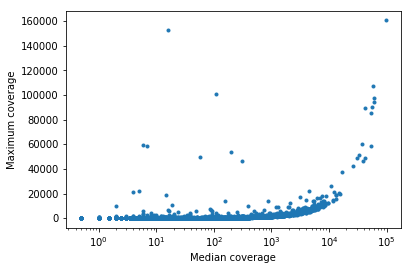

In [8]:
plt.plot(cov_sum["50%"], cov_sum["max"], '.')
plt.xscale('log')
plt.xlabel("Median coverage")
plt.ylabel("Maximum coverage")

## Outliers

I fit a curve to the data (median vs. standard deviation) and identified outliers by setting a threshold on the normalized residuals.

In [9]:
def curve_func(new_x, a, b):
    return (a * pow(10, b*new_x))

In [10]:
curve_fit, curve_cov = scipy.optimize.curve_fit(curve_func, np.log10(cov_sum["50%"]), cov_sum["std"])
curve_fit

/Users/lucy.li/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


array([0.25557463, 1.05478988])

Bootstrap estimate of confidence intervals

In [12]:
curve_fits = []
curve_covs = []

def processInput(i):
    selection = choices(list(range(len(cov_sum.index))), k=len(cov_sum.index), cum_weights=[1]*len(cov_sum.index))
    curve_fit_i, curve_cov_i = scipy.optimize.curve_fit(curve_func, np.log10(cov_sum["50%"].iloc[selection]), cov_sum["std"].iloc[selection])
    return curve_fit_i, curve_cov_i
 
num_cores = multiprocessing.cpu_count()
     
results = Parallel(n_jobs=num_cores)(delayed(processInput)(i) for i in range(100))


In [84]:
xdata = [float(y)/1000 for y in [x for x in range(int(np.log10(cov_sum["50%"].min()+1)), (int(np.log10(cov_sum["50%"].max()))+1)*1000)]]
ydata = [curve_func(x, curve_fit[0], curve_fit[1]) for x in xdata]






[842348,
 364144,
 878578,
 310246,
 403954,
 519815,
 824251,
 870588,
 308323,
 328597,
 92483,
 515850,
 92167,
 589105,
 162231,
 701371,
 364405,
 710,
 855312,
 847316,
 300239,
 225821,
 516500,
 541300,
 889144,
 494056,
 405009,
 286200,
 832704,
 787994,
 223570,
 388810,
 788613,
 256308,
 283679,
 428058,
 161414,
 333441,
 502412,
 723699,
 336586,
 12896,
 301006,
 607069,
 182581,
 209690,
 462400,
 769792,
 811304,
 597158,
 141700,
 87063,
 238325,
 162140,
 234640,
 292312,
 28369,
 770948,
 836212,
 184058,
 875200,
 841055,
 858872,
 472668,
 524208,
 356267,
 25181,
 232225,
 523114,
 770186,
 120688,
 522736,
 435961,
 865102,
 454054,
 839846,
 584278,
 283112,
 439662,
 577936,
 404212,
 677726,
 594908,
 4738,
 693080,
 195358,
 65959,
 682636,
 766924,
 401206,
 177052,
 198389,
 182467,
 13899,
 875460,
 879108,
 329233,
 626275,
 607876,
 722822,
 174700,
 797372,
 617846,
 27212,
 874814,
 774890,
 778341,
 214971,
 396136,
 69075,
 115126,
 74363,
 292571,

Text(0,0.5,'Standard deviation in coverage')

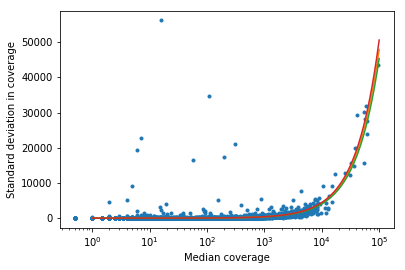

In [82]:
plt.plot(cov_sum["50%"], cov_sum["std"], '.', [pow(10, x) for x in xdata], ydata, [pow(10, x) for x in xdata], ydata_min, [pow(10, x) for x in xdata], ydata_max)
plt.xscale('log')
plt.xlabel("Median coverage")
plt.ylabel("Standard deviation in coverage")

<function tuple.count>

In [63]:
expected_values = np.log10(cov_sum["50%"]+0.000001).apply(curve_func, a=curve_fit[0][0], b=curve_fit[0][1])
residuals = abs((cov_sum["std"] - expected_values)/expected_values)
upper_residual = (residuals).quantile(q=0.999)
outliers = [i for i, x in enumerate(residuals) if (x > upper_residual) and (cov_sum["50%"][i]>0.0)]
expected = [i for i, x in enumerate(residuals) if not ((x > upper_residual) and (cov_sum["50%"][i]>0.0))]
print(len(outliers), len(expected))




73 891179


Text(0,0.5,'Standard deviation in coverage')

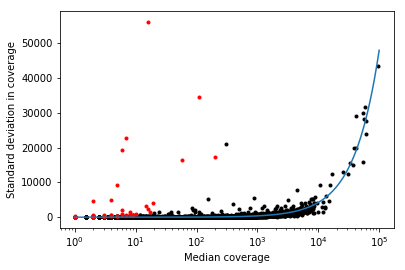

In [64]:
plt.scatter(cov_sum["50%"][expected], cov_sum["std"][expected], marker=".", c="black")
plt.scatter(cov_sum["50%"][outliers], cov_sum["std"][outliers], marker=".",  c="red")
plt.plot([pow(10, x) for x in xdata], ydata)
plt.xscale('log')
plt.xlabel("Median coverage")
plt.ylabel("Standard deviation in coverage")

In [43]:
cov_sum.iloc[outliers]

,contig_id,count,mean,std,min,25%,50%,75%,max,sample,length
35733,NODE_1077_length_835_cov_81.494723,835.0,18956.117365,34583.657364,4.0,77.0,108.0,8912.50,100750.0,CMS001_005_Ra_S3,835
52764,NODE_4870_length_455_cov_1.126984,455.0,6147.107692,9242.626845,1.0,4.0,5.0,17032.50,21986.0,CMS001_005_Ra_S3,455
99976,NODE_6193_length_457_cov_2.531579,457.0,39016.680525,56157.266309,2.0,9.0,16.0,89315.00,152920.0,CMS001_009_Ra_S13,457
135378,NODE_338_length_835_cov_369.542216,835.0,11021.372455,16430.346892,0.0,50.0,58.0,21532.00,49697.0,CMS001_014_Ra_S5,835
150497,NODE_1476_length_626_cov_43.211293,626.0,8631.239617,17225.118039,34.0,155.0,200.0,3083.75,53977.0,CMS001_016_Ra_S6,626
162186,NODE_6372_length_352_cov_0.970909,352.0,17766.656250,22832.239191,1.0,4.0,7.0,42297.50,58370.0,CMS001_016_Ra_S6,352
421168,NODE_1135_length_1291_cov_200.006590,1291.0,12380.517428,19355.465461,1.0,3.0,6.0,23984.00,59225.0,CMS002_007a_Rb_S118_L004,1291
496093,NODE_41106_length_233_cov_1.557692,233.0,3643.373391,4703.105548,1.0,2.0,2.0,9621.00,10247.0,CMS002_020a_Rb_S131_L004,233
541867,NODE_3781_length_349_cov_78.625000,349.0,18406.896848,21061.842191,0.0,253.0,306.0,43769.00,46392.0,CMS002_020e_Rb_S135_L004,349
597248,NODE_8731_length_567_cov_1.363265,567.0,1286.142857,5076.421107,1.0,3.0,4.0,8.00,21406.0,CMS002_021a_Rb_S136_L004,567


Focusing just on contigs > 1000 nt in length

In [44]:
cov_sum_long = cov_sum[cov_sum["length"]>1000]

Text(0,0.5,'Standard deviation in coverage')

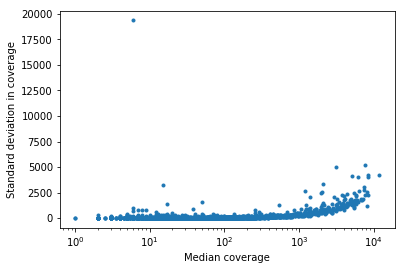

In [45]:
plt.plot(cov_sum_long["50%"], cov_sum_long["std"], '.')
plt.xscale('log')
plt.xlabel("Median coverage")
plt.ylabel("Standard deviation in coverage")

In [46]:
curve_fit_long = scipy.optimize.curve_fit(curve_func, np.log10(cov_sum_long["50%"]), cov_sum_long["std"])
curve_fit_long

(array([0.69484506, 0.92105124]), array([[ 3.20555759e-03, -5.46349164e-04],
        [-5.46349164e-04,  9.39532991e-05]]))

In [47]:
xdata_long = [float(y)/1000 for y in [x for x in range(int(np.log10(cov_sum_long["50%"].min()+1)), (int(np.log10(cov_sum_long["50%"].max())))*1000)]]
ydata_long = [curve_func(x, curve_fit_long[0][0], curve_fit_long[0][1]) for x in xdata_long]



Text(0,0.5,'Standard deviation in coverage')

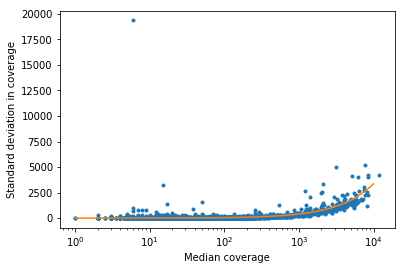

In [48]:
plt.plot(cov_sum_long["50%"], cov_sum_long["std"], '.', [pow(10, x) for x in xdata_long], ydata_long)
plt.xscale('log')
plt.xlabel("Median coverage")
plt.ylabel("Standard deviation in coverage")

In [49]:
residuals_long = (cov_sum_long["std"] - np.log10(cov_sum_long["50%"]+0.000001).apply(curve_func, a=curve_fit_long[0][0], b=curve_fit_long[0][1]))/np.sqrt(cov_sum_long["std"])
upper_residual_long = (residuals_long).quantile(q=0.999987)
outliers_long = [i for i, x in enumerate(residuals_long) if (x > upper_residual_long) and (list(cov_sum_long["50%"])[i]>0.0)]
expected_long = [i for i, x in enumerate(residuals_long) if not ((x > upper_residual_long) and (list(cov_sum_long["50%"])[i]>0.0))]
print(len(outliers_long), len(expected_long))



1 22801


Text(0,0.5,'Standard deviation in coverage')

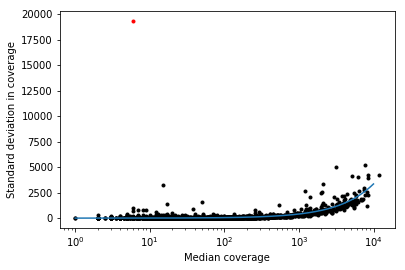

In [50]:
plt.scatter(cov_sum_long["50%"].iloc[expected_long], cov_sum_long["std"].iloc[expected_long], marker=".", c="black")
plt.scatter(cov_sum_long["50%"].iloc[outliers_long], cov_sum_long["std"].iloc[outliers_long], marker=".",  c="red")
plt.plot([pow(10, x) for x in xdata_long], ydata_long)
plt.xscale('log')
plt.xlabel("Median coverage")
plt.ylabel("Standard deviation in coverage")

In [51]:
cov_sum_long.iloc[outliers_long]

,contig_id,count,mean,std,min,25%,50%,75%,max,sample,length
421168,NODE_1135_length_1291_cov_200.006590,1291.0,12380.517428,19355.465461,1.0,3.0,6.0,23984.0,59225.0,CMS002_007a_Rb_S118_L004,1291
